# Project 2
### Devesh Mohanta
##### 02/27/2024

### The Problem
This dataset contains 12096 observations spanned across 7 variables. 6 variables are features and 1 variable is the target. The feature variables are information about the state of the car that each correlate to whether the car is evaluated as unacceptable, acceptable, good, and very good.

Considering that the problem has 6 features and the target is non-binary, the best starting point would be to use Decision Trees to train a model.

So that leaves us with the question, can we accurately predict a car's evaluation grade based on six defining features?

First we have to import the necessary libraries for this project.

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
import numpy
from numpy import interp
from itertools import cycle
import imblearn
from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Now we have to fetch the dataset from the UCI Irvine Machine Learning Repository.
However, because each variable has classification observations, it would be best to do label encoding. That way, the categorical data will be in a numerical format for the decision tree.
After that we should split the data into training and testing at a 80/20 split. 

In [2]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 

# Label encoding
le = LabelEncoder()
X_encoded = X.apply(le.fit_transform)
y_encoded = y.apply(le.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

From there, we should create and test out a beginner model with no adjustments or further training done.

In [3]:
# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 96.82080924855492%


That is an extremely high accuracy for a starting model. Now we can graph the decision tree using matplotlib.

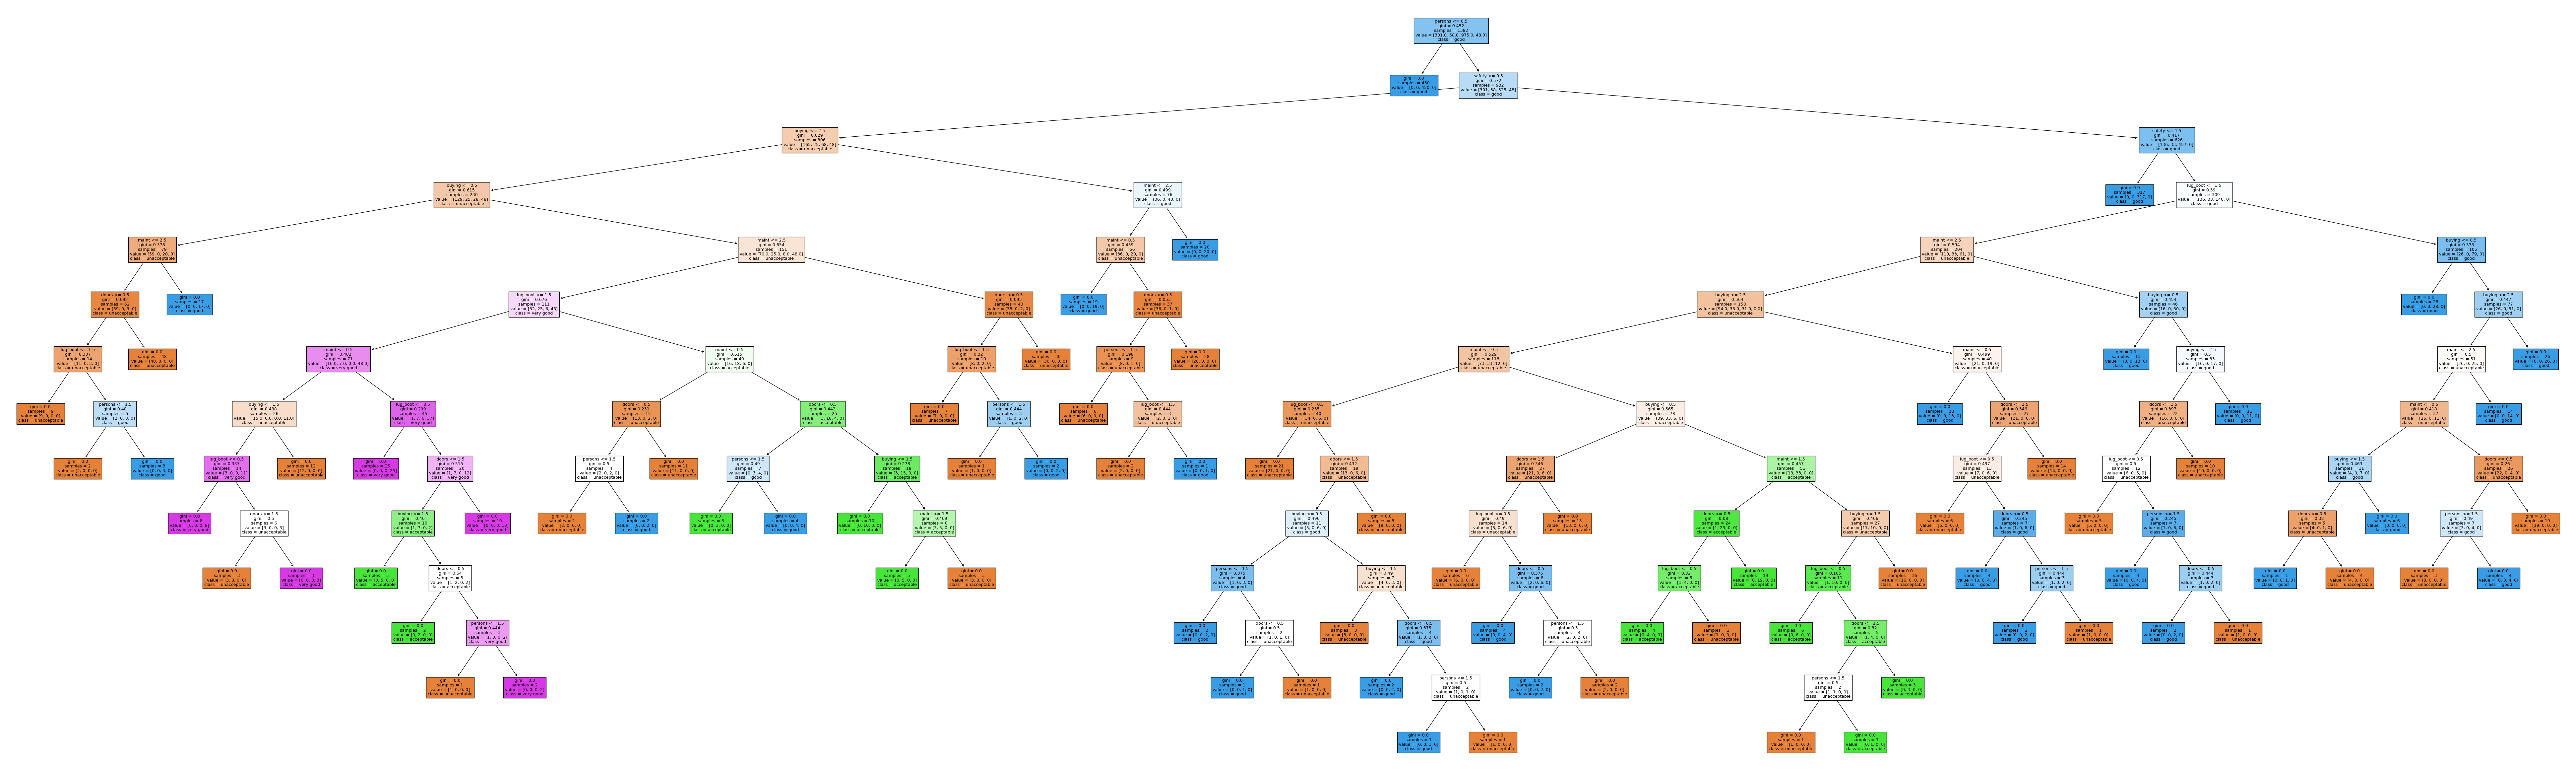

In [4]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

X_names = X.columns.tolist()
y_names = ['unacceptable', 'acceptable', 'good', 'very good']

fig = plt.figure(figsize=(100,30))
_ = tree.plot_tree(clf, 
                   feature_names=X_names,  
                   class_names=y_names,
                   filled=True)


There is a slight problem with this graph. With the amount of nodes in this tree, it is almost unreadable, and it is nearly impossible to tell which classifications lead to a car evaluation. 
While overfitting is also an issue normally, with an accuracy of 96-97% on the test data, the starter model performs great according to accuracy metrics.

For now, let's evaluate the starter model with other metrics.
Let's start with the confusion matrix. A confusion matrix has the definitions: True positive, False positive, False negative, True negative. 
Depending on the context, the worst ones would be false positive or false negative.

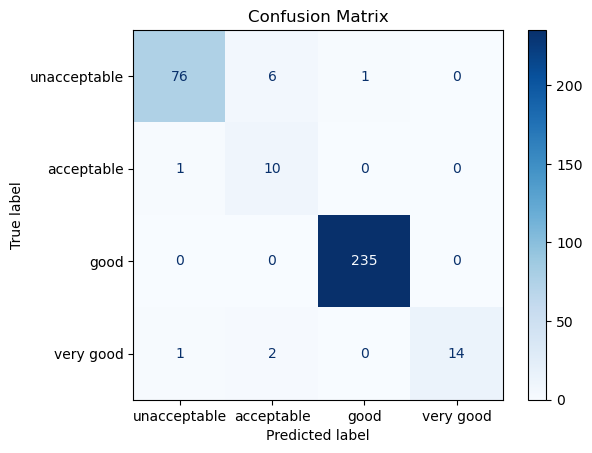

In [5]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that the model will absolutely know if a car is good. But other than that, it somewhat knows whether a car is unacceptable, and barely knows if a car is acceptable or very good, showing that accuracy was not a great metric to test the model on.
We can verify this by counting the count of each evaluation classification.

In [6]:
class_counts = y_train.value_counts()

# Print the counts
print(f"Unacceptable: {class_counts[0]}")
print(f"Acceptable: {class_counts[1]}")
print(f"Good: {class_counts[2]}")
print(f"Very good: {class_counts[3]}")

Unacceptable: 301
Acceptable: 58
Good: 975
Very good: 48


This confirms a suspicion that the training dataset is imbalanced. We will deal with that later, but we can also use F1-score and the Area Under the ROC Curve for evaluating the model itself.
Let's see the F1-score first. The F1 score is composed of the precision and recall scores where precision measures the accuracy of positive predictions and recall measures how much positive samples it gathered from the total positive samples. 
The F1 score itself uses harmonic mean which means if the precision and recall are further apart from each other, the score is worse. So the higher the score, the better.

In [7]:
# Predict probabilities for the test dataset
y_pred_probs = clf.predict_proba(X_test)

# For F1-score, you will predict the classes directly
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' takes into account label imbalance
print(f"F1-score: {f1}")

F1-score: 0.9705270393773392


Now let's see the AUC-ROC curve. This curve consists of the true positive rate (recall) and the false positive rate. The AUC itself measures a combined measure of performance across the evaluation classifications in this model.

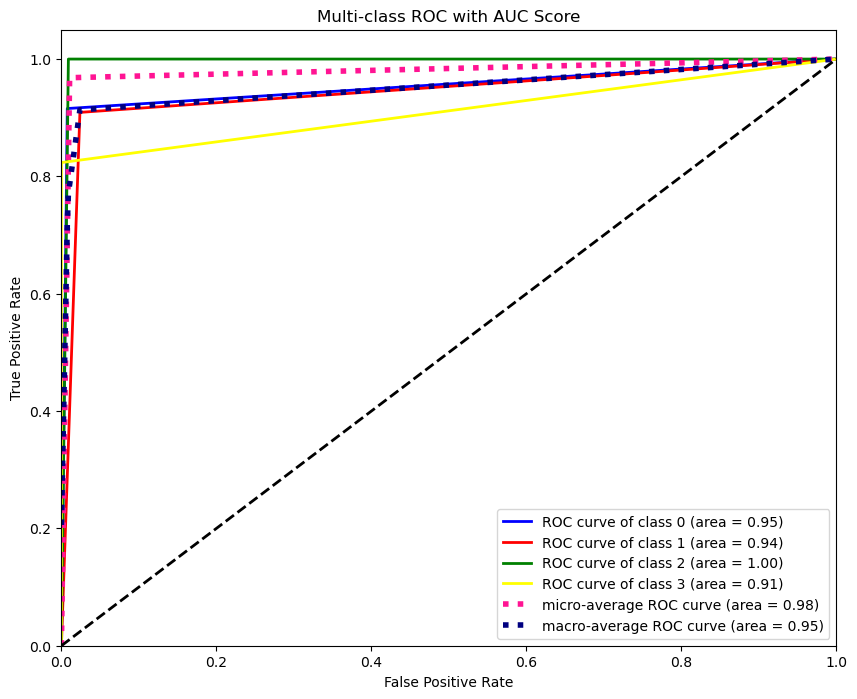

In [8]:
# Binarizing the output for multiclass ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average the TPRs and compute the AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC with AUC Score')
plt.legend(loc="lower right")
plt.show()

The AUC ROC score for each class (0, 1, 2, 3 refers to unacceptable, acceptable, good, and very good respectively) is above 90% which would basically be a grade A in terms of classification effectiveness.

It is time to start modifying the model to have a more consistent prediction across all evaluations, and not just the acceptable evaluation.

To do so, we can start pruning the tree (so it has less depth and is more readable). Let's start off with this.

In [9]:
clf2 = DecisionTreeClassifier(
    max_depth=6,                # Limit the depth of the tree
    min_samples_split=10,       # Minimum number of samples required to split an internal node
    min_samples_leaf=10,        # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=30,          # Limit the maximum number of leaf nodes
    random_state=42             # Ensuring a reproducible result
)

# Train the model using the training sets
clf2.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred2 = clf2.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 89.30635838150289%


No matter what, it seems that the biggest impact on the model is the max_depth. So for now, having a depth of 6 (opposed to 13) should be good enough for readability whilst maintaining most of the accuracy.

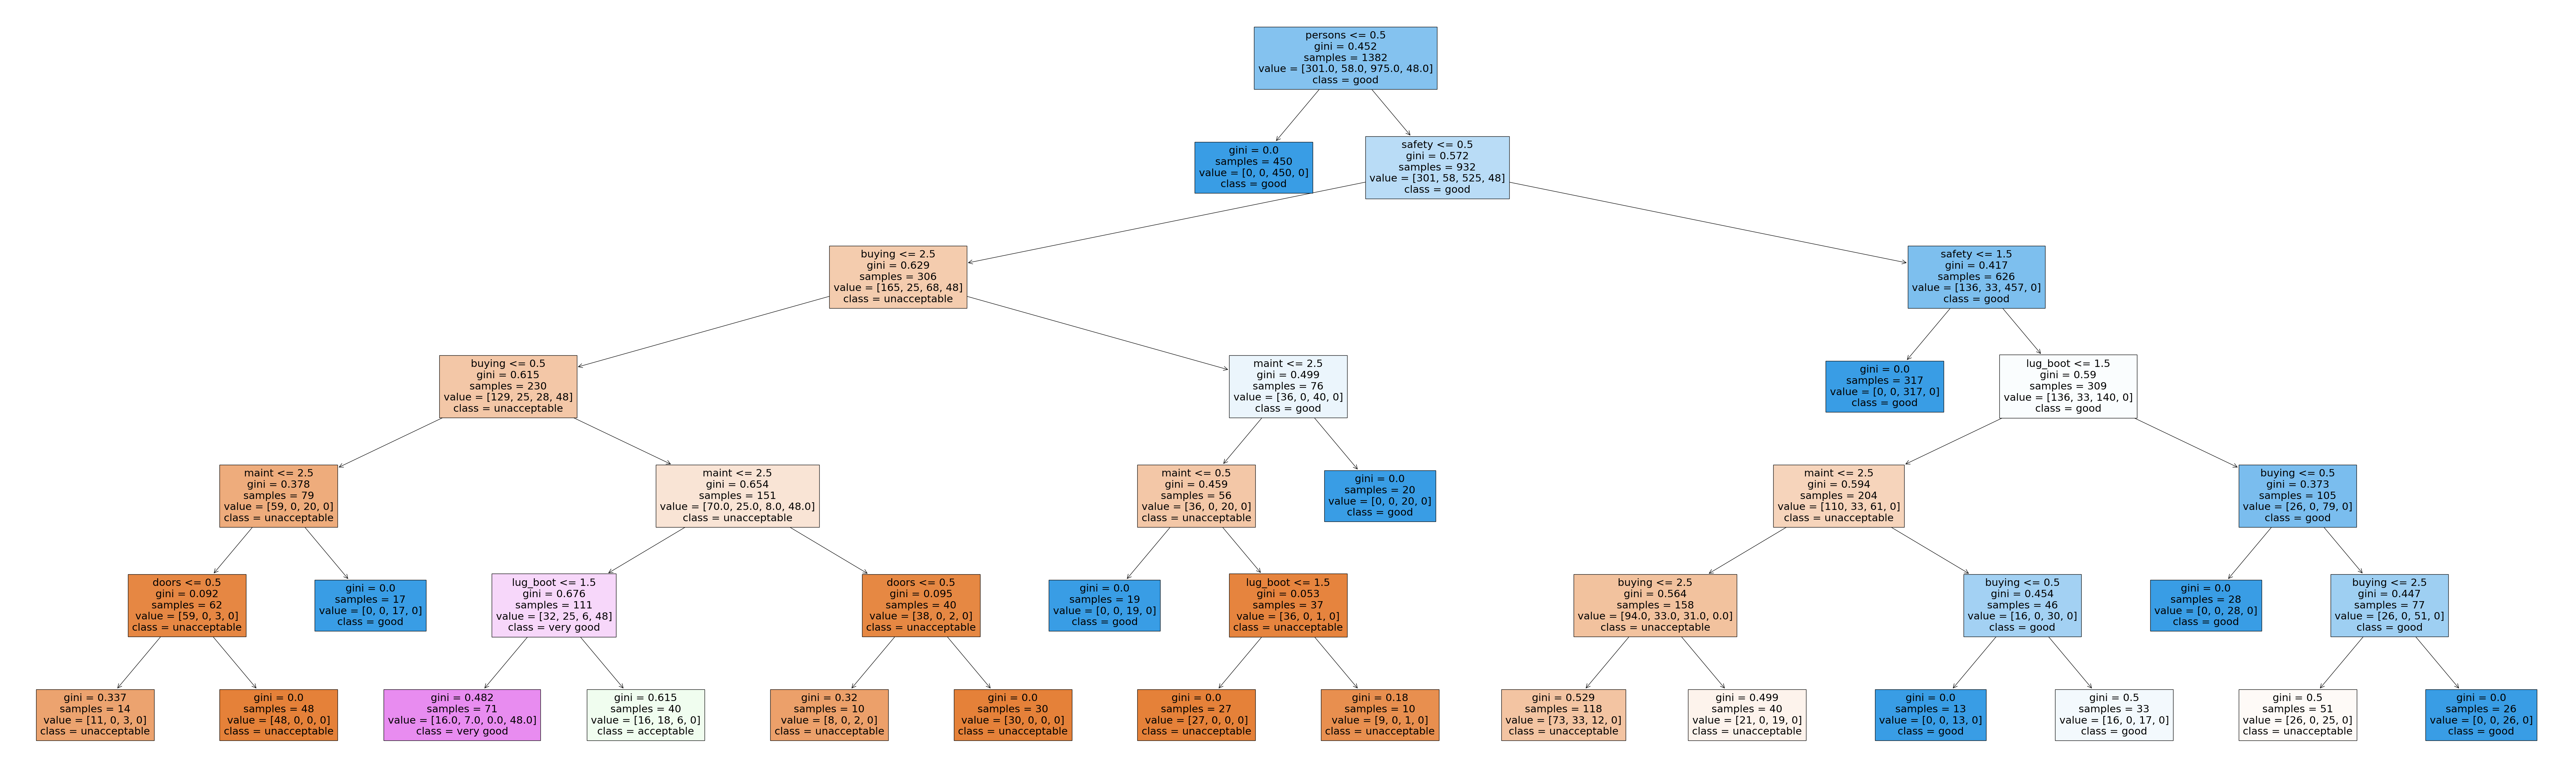

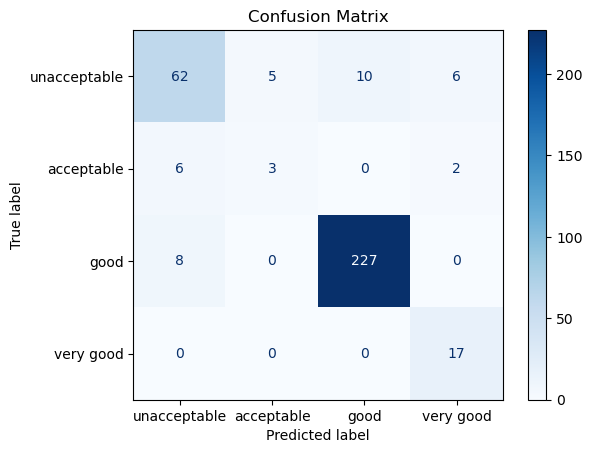

In [10]:
fig = plt.figure(figsize=(100,30))
_ = tree.plot_tree(clf2, 
                   feature_names=X_names,  
                   class_names=y_names,
                   filled=True)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Now because there is a gap between the evaluations in the data set (with most observations being good) we can use techniques such as oversampling and undersampling. 

Oversampling increases the amount of observations for minority classifications synthetically (aka making up points). This is to bring a heavier weight to those classifications versus the majority classification(s).

Undersampling does the opposite, reduce the majority classification in order to reduce the weight of those classifications.

In [11]:
# We will undersample the 'Good' class to 600 samples
undersample_strategy = {2 : 600}  # Adjust the key to match the encoded label for 'Good'

# Define the resampling pipeline
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=10))  # n_neighbors can be adjusted
])

# Apply the pipeline to the training data only
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

class_counts2 = y_train_resampled.value_counts()

# Print the counts
print(f"Unacceptable: {class_counts2[0]}")
print(f"Acceptable: {class_counts2[1]}")
print(f"Good: {class_counts2[2]}")
print(f"Very good: {class_counts2[3]}")

Unacceptable: 600
Acceptable: 600
Good: 600
Very good: 600


In [12]:
# Train the model using the training sets
clf2.fit(X_train_resampled, y_train_resampled)

# Predict the response for the test dataset
y_pred3 = clf2.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred3)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 80.92485549132948%


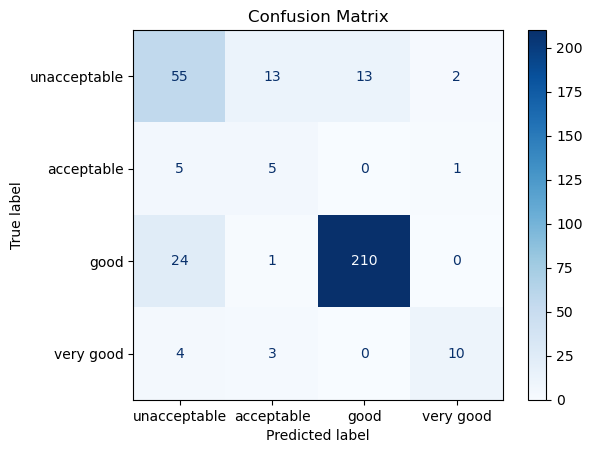

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

As we can see, even with oversampling and undersampling techniques, while it is less accurate on good, there are at least more values in the matrix, meaning the model is at least attempting to guess the other labels. With that being said, the accuracy and confusion matrix do so that the model has grown considerably worse. This means we will have to try another method.

Let's try to assign weights to each classification instead. Since there is a large disparity between each classification (because of good) it would be best to try to assign weights that make each classification proportional. Even if there is less accuracy overall, hopefully it gets better at predicting other classifications besides good.

In [14]:
# Define the class weights according to your specified order
class_weights = {3 : 20, 1 : 15, 0 : 3, 2 : 1}

# Normalize the weights so that the minority class has a weight of 1
max_weight = max(class_weights.values())
class_weights = {i: weight / max_weight for i, weight in class_weights.items()}
print(class_weights)

clf3 = DecisionTreeClassifier(
    class_weight=class_weights,
    max_depth=8,                # Limit the depth of the tree
    min_samples_split=20,       # Minimum number of samples required to split an internal node
    min_samples_leaf=10,        # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=30,          # Limit the maximum number of leaf nodes
    random_state=42             # Ensuring a reproducible result
)

# Train the model using the training sets
clf3.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred4 = clf3.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred4)
print(f"Accuracy with proportional class weights: {accuracy*100}%")

{3: 1.0, 1: 0.75, 0: 0.15, 2: 0.05}
Accuracy with proportional class weights: 91.61849710982659%


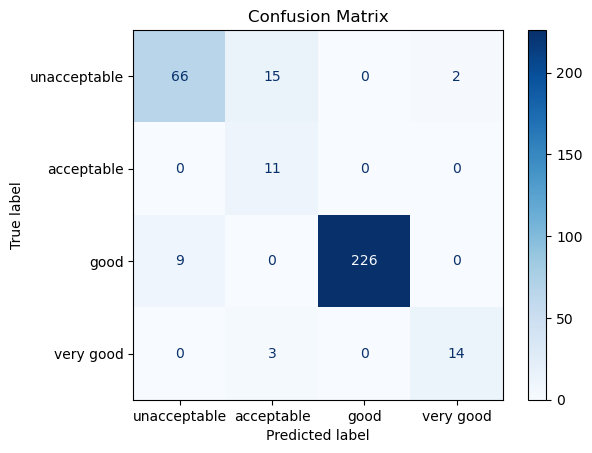

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred4)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Weights helped a lot more with the decreased depth decision tree. However, it did not really impact anything on the confusion matrix, so we can introduce another method called the random forest. This method helps with minority classes and is an ensemble learning method. They prevent overfitting (in this case to good classification) by averaging out the biases across many decision trees.

In [16]:
# Reshape y_train to be a 1D array
y_train = np.ravel(y_train)

clf4 = RandomForestClassifier(
    class_weight=class_weights,
    n_estimators=45,           # The number of trees in the forest
    max_depth=7,                # The maximum depth of the tree
    min_samples_split=20,       # The minimum number of samples required to split an internal node
    min_samples_leaf=10,        # The minimum number of samples required to be at a leaf node
    max_leaf_nodes=30,          # Grow trees with max_leaf_nodes in best-first fashion
    random_state=42             # Ensuring a reproducible result
)

# Train the model using the training sets
clf4.fit(X_train, y_train)
y_pred5 = clf4.predict(X_test)
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred5)
print(f"Accuracy with proportional class weights: {accuracy*100}%")

Accuracy with proportional class weights: 91.61849710982659%


Let's also print out the confusion matrix and the AUC-ROC graph similar to the one printed earlier.

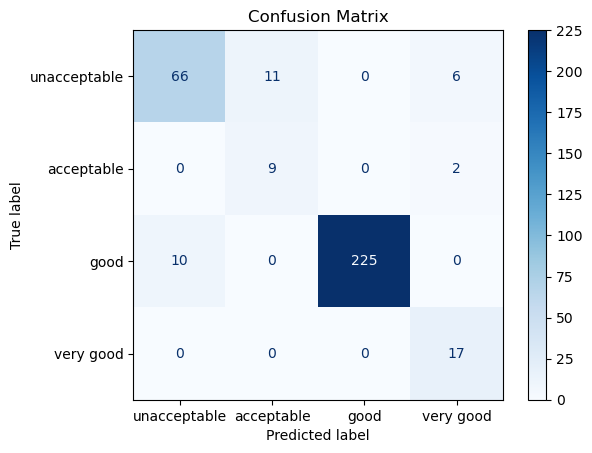

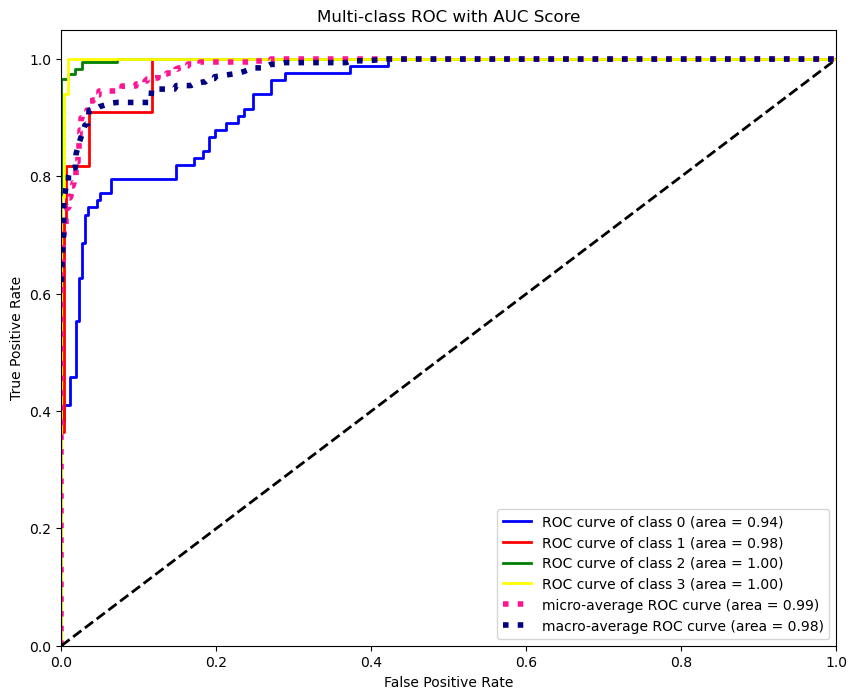

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred5)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Predict probabilities for the test dataset
y_pred_probs4 = clf4.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs4[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs4.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the TPRs and compute the AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC with AUC Score')
plt.legend(loc="lower right")
plt.show()

Let's try one last ensemble method. One such method is boosting, which trains models in sequence and each model after the previous attempts to correct the mistake of the previous ones. Let's use the AdaBoost classifer for this boosting method.

In [18]:
# Train the model using the training sets
clf5 = AdaBoostClassifier(
    estimator=clf4,
    n_estimators=100,           # The maximum number of estimators at which boosting is terminated
    algorithm='SAMME',         # Specify the algorithm to be used
    random_state=42            # Ensuring a reproducible result
)
clf5.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred6 = clf5.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred6)
print(f"Accuracy with proportional class weights: {accuracy*100}%")


Accuracy with proportional class weights: 98.84393063583815%


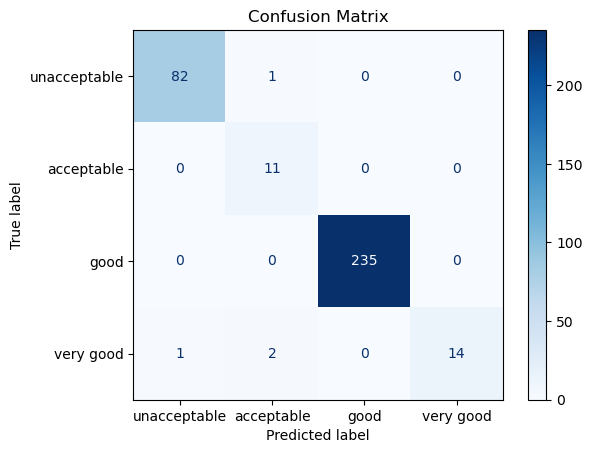

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred6)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The accuracy is now higher to the original model, however, it more or less performs the same amount as the inital model. Only difference this time is that there is less depth on the decision tree, or rather decision trees on the new model.

Since it is impossible to visualize a random forest, much less the the full AdaBoost model, there are other ways we can visualize the performance of this model now.

For instance, we can plot feature importances to see which features are necessary in making predictions.

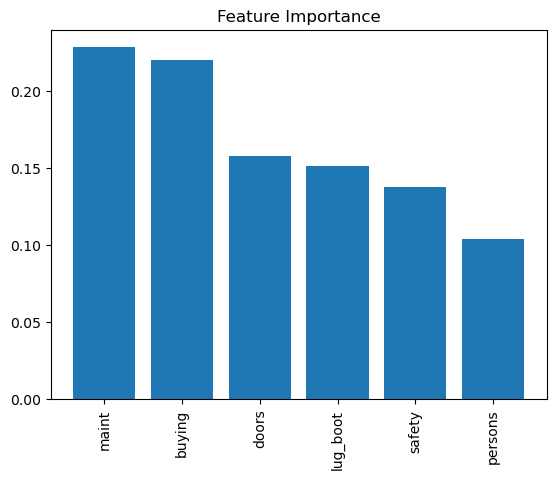

In [20]:
# Get feature importances
importances = clf5.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

As we can see, maintenance and buying price is the most essential features in predictions being over 0.20 in importance. The least essential is persons, though it is still influential being just above 0.10 in importance.

Let's graph the AUC-ROC and print the F1 score again for the AdaBoost model.

F1-score: 0.9885399962707441


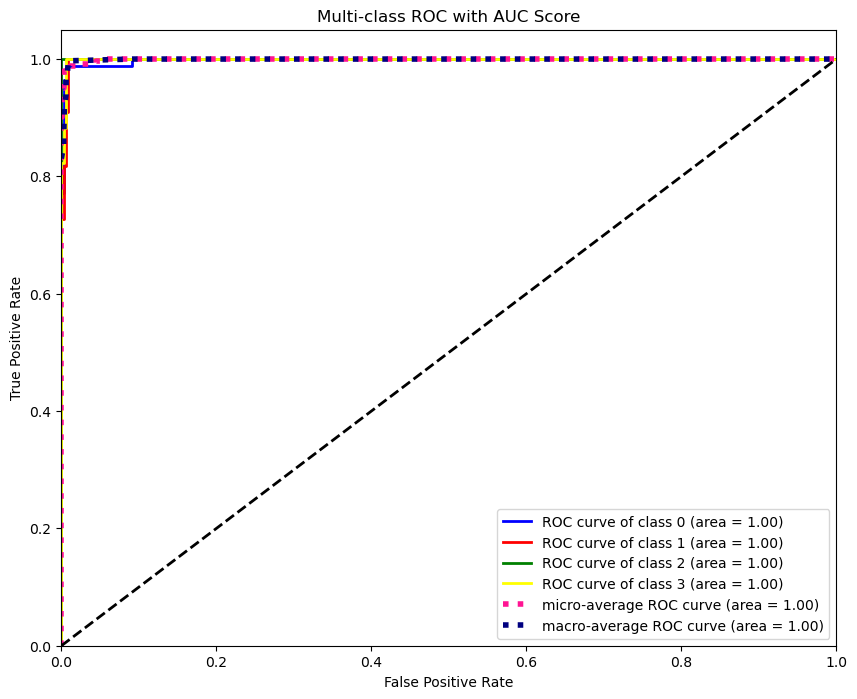

In [21]:
f1 = f1_score(y_test, y_pred6, average='weighted')  # 'weighted' takes into account label imbalance
print(f"F1-score: {f1}")

# Predict probabilities for the test dataset
y_pred_probs5 = clf5.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs5[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs5.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the TPRs and compute the AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC with AUC Score')
plt.legend(loc="lower right")
plt.show()

As we can see either this model is the best one ever created, or the model is overfitted. Given the confusion matrix, it would make sense that the model is still overfitted based on the good classification.

# Conclusion
In the end, we somewhat answered the question set at the beginning of this project. We can somewhat accurately predict of the classifications in the dataset. However, there are more false positives and negatives in each model iteration. In the end, the problem lies with the classification disparity between good, unacceptable, and especially very good and acceptable. 

If there could be any further improvements, the dataset itself needs some fine tuning so that the machine learning process can work to the fullest extent.

### Citation
Bohanec, Marko. (1997). Car Evaluation. UCI Machine Learning Repository. https://doi.org/10.24432/C5JP48.